# OHBM 2021 NiMARE tutorial

## What is NiMARE?

[NiMARE](https://nimare.readthedocs.io/en/latest/) is a Python library for performing neuroimaging meta-analyses and related analyses, like automated annotation and functional decoding.

## Goals for this tutorial

1. Working with NiMARE meta-analytic datasets
1. Searching large datasets
1. Performing coordinate-based meta-analyses
1. Performing image-based meta-analyses

In [ ]:
# Import the packages we'll need for this tutorial
%matplotlib inline
import json
import os.path as op
from pprint import pprint

import matplotlib.pyplot as plt
from nilearn import plotting, reporting

import nimare

In [ ]:
DATA_DIR = op.abspath("../data/nimare_tutorial/osfstorage/")

# Basics of NiMARE datasets
NiMARE relies on a specification for meta-analytic datasets named [NIMADS](https://github.com/neurostuff/NIMADS). Under NIMADS, meta-analytic datasets are stored as JSON files, with information about peak coordinates, _relative_ links to any unthresholded statistical images, metadata, annotations, and raw text.

**NOTE**: NiMARE users generally do not need to create JSONs manually, so we won't go into that structure in this tutorial. Instead, users will typically have access to datasets stored in more established formats, like [Neurosynth](https://github.com/neurosynth/neurosynth-data) and [Sleuth](http://brainmap.org/sleuth/) files.

We will start by loading a dataset in NIMADS format, because this particular dataset contains both coordinates and images. This dataset is created from [Collection 1425 on NeuroVault](https://identifiers.org/neurovault.collection:1425), which contains [NIDM-Results packs](http://nidm.nidash.org/specs/nidm-results_130.html) for 21 pain studies.

In [ ]:
pain_dset = nimare.dataset.Dataset(op.join(DATA_DIR, "nidm_pain_dset.json"))

# In addition to loading the NIMADS-format JSON file,
# we need to download the associated statistical images from NeuroVault,
# for which NiMARE has a useful function.
dset_dir = nimare.extract.download_nidm_pain(data_dir=DATA_DIR)

# We then notify the Dataset about the location of the images,
# so that the *relative paths* in the Dataset can be used to determine *absolute paths*.
pain_dset.update_path(dset_dir)

In NiMARE, datasets are stored in a special `Dataset` class. The `Dataset` class stores most relevant information as properties.

The full list of identifiers in the Dataset is located in `Dataset.ids`. Identifiers are composed of two parts- a study ID and a contrast ID. Within the Dataset, those two parts are separated with a `-`.

In [ ]:
print(pain_dset.ids)

Most other information is stored in `pandas` DataFrames. The five DataFrame-based attributes are `Dataset.metadata`, `Dataset.coordinates`, `Dataset.images`, `Dataset.annotations`, and `Dataset.texts`.

Each DataFrame contains at least three columns: `study_id`, `contrast_id`, and `id`, which is the combined `study_id` and `contrast_id`.

In [ ]:
pain_dset.coordinates.head()

In [ ]:
pain_dset.metadata.head()

In [ ]:
pain_dset.images.head()

In [ ]:
pain_dset.annotations.head()

In [ ]:
pain_dset.texts.head()

Other relevant attributes are `Dataset.masker` and `Dataset.space`.

`Dataset.masker` is a [nilearn Masker object](https://nilearn.github.io/manipulating_images/masker_objects.html#), which specifies the manner in which voxel-wise information like peak coordinates and statistical images are mapped into usable arrays. Most meta-analytic tools within NiMARE accept a `masker` argument, so the Dataset's masker can be overridden in most cases.

`Dataset.space` is just a string describing the standard space and resolution in which data within the Dataset are stored.

In [ ]:
pain_dset.masker

In [ ]:
pain_dset.space

Datasets can also be saved to, and loaded from, binarized (pickled) files.

We cannot save files on Binder, so here is the code we would use to save the pain Dataset:

```python
pain_dset.save("pain_dataset.pkl.gz")
```

Now for a more common situation, where users want to use NiMARE on data from Neurosynth or a Sleuth file.

Downloading and converting the Neurosynth dataset takes a long time, so we will use a pregenerated version of the dataset. However, here is the code we would use to download and convert the dataset from scratch:

```python
nimare.extract.fetch_neurosynth("data/", unpack=True)
ns_dset = nimare.io.convert_neurosynth_to_dataset(
    "data/database.txt",
    "data/features.txt",
)
```

In [ ]:
ns_dset = nimare.dataset.Dataset.load(op.join(DATA_DIR, "neurosynth_dataset.pkl.gz"))
print(f"There are {len(ns_dset.ids)} studies in the Neurosynth database.")

In [ ]:
sleuth_dset = nimare.io.convert_sleuth_to_dataset(op.join(DATA_DIR, "sleuth_dataset.txt"))
print(f"There are {len(sleuth_dset.ids)} studies in this dataset.")

## Searching large datasets

The `Dataset` class contains multiple methods for selecting subsets of studies within the dataset.

One common approach is to search by "labels" or "terms" that apply to studies. In Neurosynth, labels are derived from term frequency within abstracts.

The `slice` method creates a reduced `Dataset` from a list of IDs.

In [ ]:
pain_ids = ns_dset.get_studies_by_label("Neurosynth_TFIDF__pain", label_threshold=0.001)
ns_pain_dset = ns_dset.slice(pain_ids)
print(f"There are {len(pain_ids)} studies labeled with 'pain'.")

A MACM (meta-analytic coactivation modeling) analysis is generally performed by running a meta-analysis on studies with a peak in a region of interest, so Dataset includes two methods for searching based on the locations of coordinates: `Dataset.get_studies_by_coordinate` and `Dataset.get_studies_by_mask`.

In [ ]:
sphere_ids = ns_dset.get_studies_by_coordinate([[24, -2, -20]], r=6)
sphere_dset = ns_dset.slice(sphere_ids)
print(f"There are {len(sphere_ids)} studies with at least one peak within 6mm of [24, -2, -20].")

# Running meta-analyses

## Coordinate-based meta-analysis

Most coordinate-based meta-analysis algorithms are kernel-based, in that they convolve peaks reported in papers with a "kernel". Kernels are generally either binary spheres, as in multi-level kernel density analysis (MKDA), or 3D Gaussian distributions, as in activation likelihood estimation (ALE).

NiMARE includes classes for different kernel transformers, which accept Datasets and generate the images resulting from convolving each study's peaks with the associated kernel.

In [ ]:
# Create a figure
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

# Apply different kernel transformers to the same Dataset
kernels = [
    nimare.meta.kernel.MKDAKernel(r=10),
    nimare.meta.kernel.KDAKernel(r=10),
    nimare.meta.kernel.ALEKernel(sample_size=20),
]

for i_kernel, kernel in enumerate(kernels):
    ma_maps = kernel.transform(pain_dset, return_type="image")

    # Plot the kernel
    plotting.plot_stat_map(
        ma_maps[0],
        annotate=False,
        axes=axes[i_kernel],
        cmap="Reds",
        cut_coords=[0, 0, -24],
        draw_cross=False,
        figure=fig,
        title=type(kernel),
    )

# Show the overall figure
fig.show()

Meta-analytic Estimators are initialized with parameters which determine how the Estimator will be run. For example, ALE accepts a kernel transformer (which defaults to the standard `ALEKernel`), a null method, the number of iterations used to define the null distribution, and the number of cores to be used during fitting.

The Estimators also have a `fit` method, which accepts a `Dataset` object and returns a `MetaResult` object. [`MetaResult`s](https://nimare.readthedocs.io/en/latest/generated/nimare.results.MetaResult.html#nimare.results.MetaResult) link statistical image names to numpy arrays, and can be used to produce nibabel images from those arrays, as well as save the images to files.

In [ ]:
meta = nimare.meta.cbma.ale.ALE(null_method="approximate")
meta_results = meta.fit(pain_dset)

In [ ]:
print(type(meta_results))

In [ ]:
print(type(meta_results.maps))
print("Available maps:")
print("\t- " + "\n\t- ".join(meta_results.maps.keys()))

In [ ]:
z_img = meta_results.get_map("z")
print(type(z_img))

In [ ]:
plotting.plot_stat_map(
    z_img,
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

## Multiple comparisons correction

Most of the time, you will want to follow up your meta-analysis with some form of multiple comparisons correction. For this, NiMARE provides Corrector classes in the `correct` module. Specifically, there are two Correctors: [`FWECorrector`](https://nimare.readthedocs.io/en/latest/generated/nimare.correct.FWECorrector.html) and [`FDRCorrector`](https://nimare.readthedocs.io/en/latest/generated/nimare.correct.FDRCorrector.html). In both cases, the Corrector supports a range of naive correction options relying on [`statsmodels`' methods](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html).

In addition to generic multiple comparisons correction, the Correctors also reference algorithm-specific correction methods, such as the `montecarlo` method supported by most coordinate-based meta-analysis algorithms.

Correctors are initialized with parameters, and they have a `transform` method that accepts a `MetaResult` object and returns an updated one with the corrected maps.

In [ ]:
mc_corrector = nimare.correct.FWECorrector(
    method="montecarlo", 
    n_iters=100,
    n_cores=1,
)
mc_results = mc_corrector.transform(meta_results)

# Let's store the CBMA result for later
cbma_z_img = mc_results.get_map("z_level-cluster_corr-FWE_method-montecarlo")

In [ ]:
print(type(mc_results.maps))
print("Available maps:")
print("\t- " + "\n\t- ".join(mc_results.maps.keys()))

In [ ]:
plotting.plot_stat_map(
    mc_results.get_map("z_level-cluster_corr-FWE_method-montecarlo"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

In [ ]:
# Report a standard cluster table for the meta-analytic map using a threshold of p<0.05
reporting.get_clusters_table(cbma_z_img, stat_threshold=1.65)

## Image-based meta-analysis

In [ ]:
pain_dset.images

Note that "z" images are missing for some, but not all, of the studies.

NiMARE's `transforms` module contains a function, `transform_images`, which can generate images from other images- as long as the right images and metadata are available. In this case, it can generate z-statistic images from t-statistic maps, combined with sample size information in the metadata. It can also generate "varcope" (contrast variance) images from the contrast standard error images.

In [ ]:
# Calculate missing images
pain_dset.images = nimare.transforms.transform_images(
    pain_dset.images,
    target="z",
    masker=pain_dset.masker,
    metadata_df=pain_dset.metadata,
)
pain_dset.images = nimare.transforms.transform_images(
    pain_dset.images,
    target="varcope",
    masker=pain_dset.masker,
    metadata_df=pain_dset.metadata,
)

In [ ]:
pain_dset.images.head()

Now that we have all of the image types we will need for our meta-analyses, we can run a couple of image-based meta-analysis types.

The `DerSimonianLaird` method uses "beta" and "varcope" images, and estimates between-study variance (a.k.a. $\tau^2$).

In [ ]:
meta = nimare.meta.ibma.DerSimonianLaird()
meta_results = meta.fit(pain_dset)

In [ ]:
plotting.plot_stat_map(
    meta_results.get_map("z"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

The `PermutedOLS` method uses z-statistic images, and relies on [nilearn's `permuted_ols`](https://nilearn.github.io/modules/generated/nilearn.mass_univariate.permuted_ols.html) tool.

In [ ]:
meta = nimare.meta.ibma.PermutedOLS()
meta_results = meta.fit(pain_dset)

In [ ]:
plotting.plot_stat_map(
    meta_results.get_map("z"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

In [ ]:
mc_corrector = nimare.correct.FWECorrector(method="montecarlo", n_iters=100)
mc_results = mc_corrector.transform(meta_results)

In [ ]:
print(type(mc_results.maps))
print("Available maps:")
print("\t- " + "\n\t- ".join(mc_results.maps.keys()))

In [ ]:
plotting.plot_stat_map(
    mc_results.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

In [ ]:
# Report a standard cluster table for the meta-analytic map using a threshold of p<0.05
reporting.get_clusters_table(
    mc_results.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    stat_threshold=1.65,
    cluster_threshold=10,
)

## Compare to results from the SPM IBMA extension

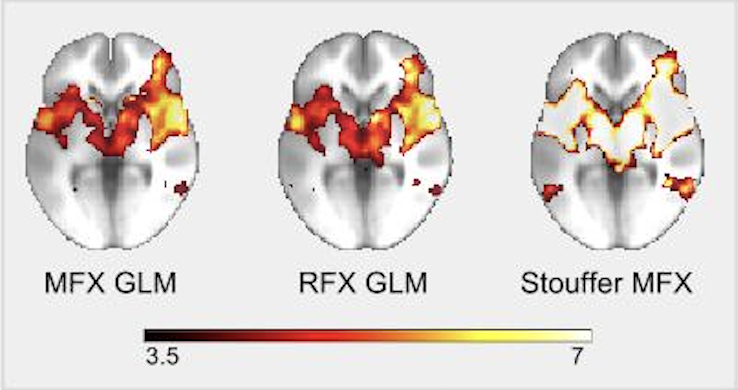
Adapted from [Maumet & Nichols (2014)](https://www.frontiersin.org/10.3389/conf.fninf.2014.18.00025/event_abstract).

In [ ]:
plotting.plot_stat_map(
    mc_results.get_map("z_level-voxel_corr-FWE_method-montecarlo"),
    threshold=1.65,
    vmax=3,
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

In [ ]:
plotting.plot_stat_map(
    cbma_z_img,
    threshold=1.65,
    vmax=3,
    draw_cross=False,
    cut_coords=[0, 0, 0],
)

# Meta-Analytic Functional Decoding

Functional decoding refers to approaches which attempt to infer mental processes, tasks, etc. from imaging data. There are many approaches to functional decoding, but one set of approaches uses meta-analytic databases like Neurosynth or BrainMap, which we call "meta-analytic functional decoding." For more information on functional decoding in general, read [Poldrack (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3240863/).

In NiMARE, we group decoding methods into three general types: discrete decoding, continuous decoding, and encoding.

Discrete decoding methods use a meta-analytic database and annotations of studies in that database to describe something discrete (like a region of interest) in terms of those annotations.

Continuous decoding methods use the same type of database to describe an unthresholded brain map in terms of the database's annotations. One example of this kind of method is the Neurosynth-based decoding available on Neurovault. In that method, the map you want to decode is correlated with Neurosynth term-specific meta-analysis maps. You end up with one correlation coefficient for each term in Neurosynth. Users generally report the top ten or so terms.

Encoding methods do the opposite- they take in annotations or raw text and produce a synthesized brain map. One example of a meta-analytic encoding tool is [NeuroQuery](https://neuroquery.org/).

# Exercise: Run a MACM and Decode an ROI

First, we have to prepare some things for the exercise. You just need to run these cells without editing anything.

In [ ]:
ROI_FILE = op.join(DATA_DIR, "amygdala_roi.nii.gz")

plotting.plot_roi(
    ROI_FILE,
    title="Anterior Cingular Gyrus",
    draw_cross=False,
)

In [ ]:
# Given the sheer size of Neurosynth, we will only use the first 500 studies in this exercise
ns_dset = ns_dset.slice(ns_dset.ids[:500])

Below, try to write code in each cell based on its comment.

In [ ]:
# First, use the Dataset class's get_studies_by_mask method
# to identify studies with at least one coordinate in the ROI.
roi_studies = ns_dset.get_studies_by_mask(ROI_FILE)
print(len(roi_studies))

In [ ]:
# Now, create a reduced version of the Dataset including only
# studies identified above.
roi_dset = ns_dset.slice(roi_studies)

In [ ]:
# Next, run a meta-analysis on the reduced ROI dataset.
# This is a MACM.
macm = nimare.meta.cbma.ale.ALE(kernel__sample_size=20)
macm.fit(roi_dset)
plotting.plot_stat_map(macm.results.get_map("z"))

In [ ]:
# Initialize, fit, and transform a Neurosynth Decoder.
decoder = nimare.decode.discrete.NeurosynthDecoder()
decoder.fit(ns_dset)
roi_dataframe = decoder.transform(ids=roi_studies)

In [ ]:
# Show the results
roi_dataframe

In [ ]:
roi_dataframe.sort_values(by="pReverse", ascending=True).head(10)